# Vision por Computadoras II - TP (17Co2024)

#### Alumnos
- Adassus, Luciano
- Ignacio Tomas De Pedro Mermier
- Jhonatan Cagua


---

**Objetivo del Proyecto:**

Entrenar un modelo para detectar signos iniciales de incendios forestales, como humo, en im√°genes satelitales.

El enfoque est√° centrado en la **detecci√≥n temprana**, lo que implica identificar visualmente patrones sutiles que preceden al fuego activo, como la aparici√≥n de columnas de humo.

En este proyecto se cuenta con anotaciones en formato **YOLO**, por lo tanto el enfoque adoptado es la **detecci√≥n de objetos**. Esto significa que el modelo no solo debe identificar si hay humo, sino tambi√©n **localizarlo espacialmente dentro de la imagen** mediante bounding boxes.

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
# Si es necesario descoprimir el data set Wildfire fire satellite images.
!unzip "/content/drive/MyDrive/IA-TPs/VC2/Wildfire-Dataset/archive.zip" -d "/content/drive/MyDrive/IA-TPs/VC2/Wildfire-Dataset/dataset"

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configurar rutas de los datos (ajustarlo seg√∫n la organizaci√≥n en el Drive)
DATA_DIR = '/content/drive/MyDrive/IA-TPs/VC2/wildfire/dataset'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

## Analisis exploratario de Datos

### 1 - Estructura del dataset

In [ ]:
for name, path in {
    "x_train_dir": x_train_dir,
    "y_train_dir": y_train_dir,
    "x_valid_dir": x_valid_dir,
    "y_valid_dir": y_valid_dir,
    "x_test_dir": x_test_dir,
    "y_test_dir": y_test_dir
}.items():
    exists = os.path.exists(path)
    count = len(os.listdir(path)) if exists else 0
    print(f"{name}: {'‚úÖ Existe' if exists else '‚ùå No existe'} - {count} archivos")

x_train_dir: ‚úÖ Existe - 2620 archivos
y_train_dir: ‚úÖ Existe - 2620 archivos
x_valid_dir: ‚úÖ Existe - 980 archivos
y_valid_dir: ‚úÖ Existe - 980 archivos
x_test_dir: ‚úÖ Existe - 276 archivos
y_test_dir: ‚úÖ Existe - 276 archivos


### 2 - Extraer metainformaci√≥n de una muestra de im√°genes

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd

def analyze_images(folder_path, sample_size=500):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))][:sample_size]
    data = []
    for file in image_files:
        try:
            img_path = os.path.join(folder_path, file)
            with Image.open(img_path) as img:
                arr = np.array(img)
                data.append({
                    'filename': file,
                    'format': img.format,
                    'mode': img.mode,
                    'width': img.width,
                    'height': img.height,
                    'mean_pixel_value': arr.mean() if arr.ndim == 3 else np.nan
                })
        except Exception as e:
            data.append({'filename': file, 'error': str(e)})
    return pd.DataFrame(data)

train_df = analyze_images(x_train_dir)
train_df.head()

filename format mode  width  \
0  cal_north2021_243_8_png_jpg.rf.9f9c16d5288c3d5...   JPEG  RGB    416   
1  cal_north2020_244_22_png_jpg.rf.ef5477b13f4d32...   JPEG  RGB    416   
2  cal_north2020_255_1_png_jpg.rf.966a0f1a1fe12ce...   JPEG  RGB    416   
3  cal_north2021_249_5_png_jpg.rf.4b9a5d133eaf1fd...   JPEG  RGB    416   
4  new_fire_snapshot-2010-10-14_jpg.rf.f9f06aa0b0...   JPEG  RGB    416   

   height  mean_pixel_value  
0     416        104.982869  
1     416        153.958778  
2     416        163.131114  
3     416        108.697185  
4     416         95.653848

### 3 - Ver distribuci√≥n de tama√±os de imagen y valores de brillo

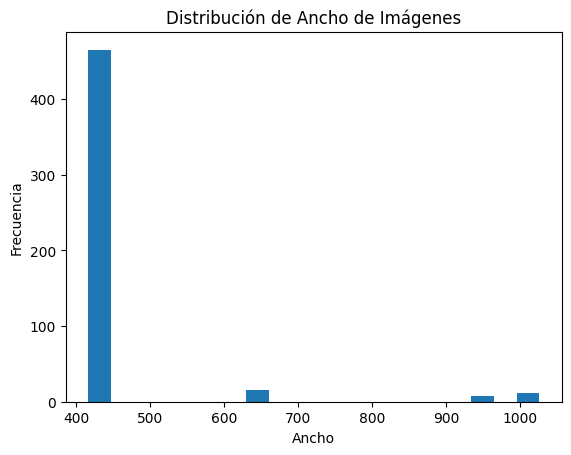

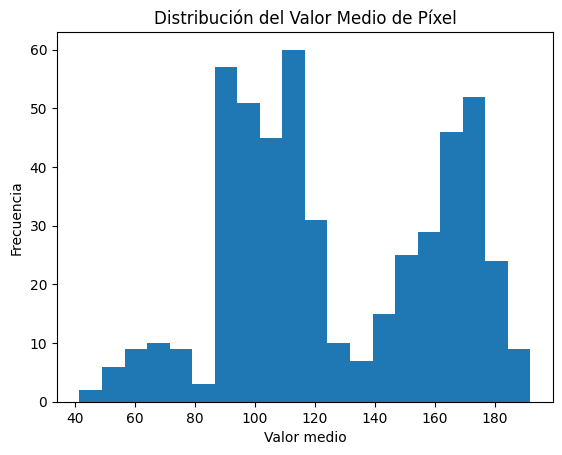

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_df['width'], bins=20)
plt.title("Distribuci√≥n de Ancho de Im√°genes")
plt.xlabel("Ancho")
plt.ylabel("Frecuencia")
plt.show()

plt.hist(train_df['mean_pixel_value'].dropna(), bins=20)
plt.title("Distribuci√≥n del Valor Medio de P√≠xel")
plt.xlabel("Valor medio")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- Claramente, la mayor√≠a tiene un ancho est√°ndar (~420 px), lo que sugiere una fuente homog√©nea.
- Tenemos algunos outliers con anchos mayores: 640, 1024, etc.
- La forma bimodal o multimodal sugiere que hay diferentes tipos de imagen en el dataset:
  - Im√°genes m√°s oscuras (valor medio entre 50-100) ‚Üí posiblemente con humo o fuego.
  - Im√°genes m√°s claras (valor medio entre 160-180) ‚Üí cielos despejados o sin incendio.

### 4 - Distribuci√≥n de cantidad de objetos por imagen

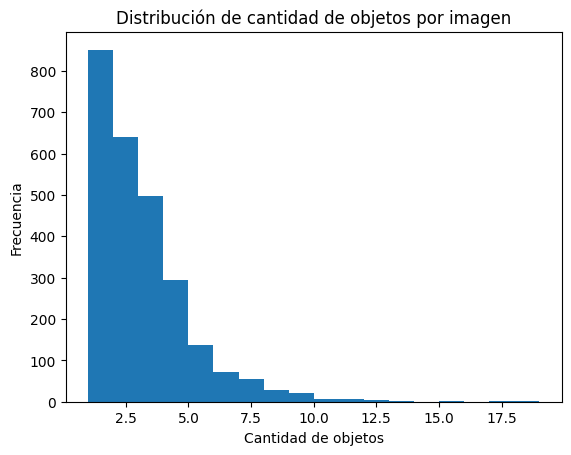

In [ ]:
label_counts = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            label_counts.append(len(f.readlines()))

plt.hist(label_counts, bins=range(1, max(label_counts)+2))
plt.title("Distribuci√≥n de cantidad de objetos por imagen")
plt.xlabel("Cantidad de objetos")
plt.ylabel("Frecuencia")
plt.show()

**Conslusiones:**
- La mayor√≠a de las im√°genes tienen entre **1 y 5 objetos** etiquetados.
- Son pocos los casos con m√°s de 10 objetos por imagen.
- Esto sugiere una anotaci√≥n precisa y controlada, ideal para entrenamiento.

### 5 - Mostrar algunas im√°genes al azar

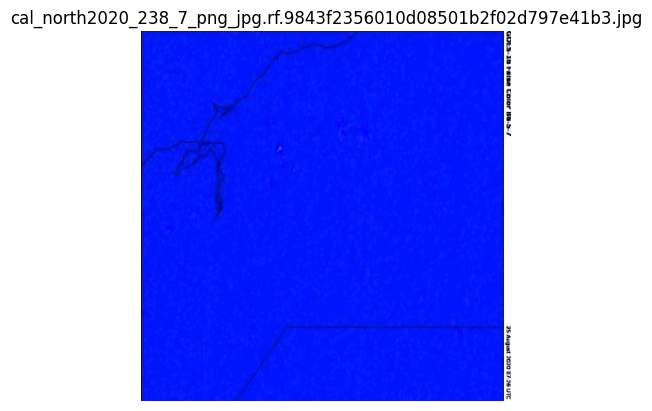

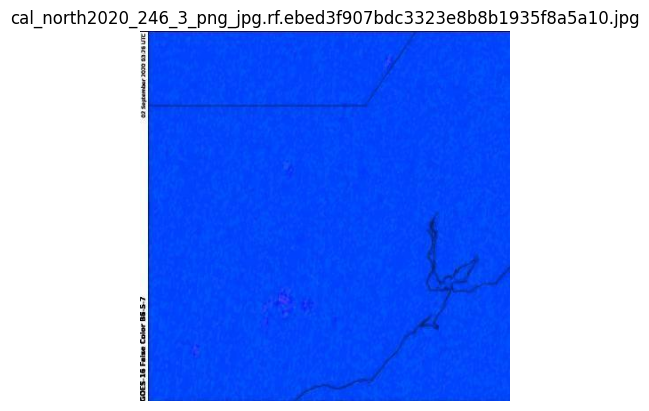

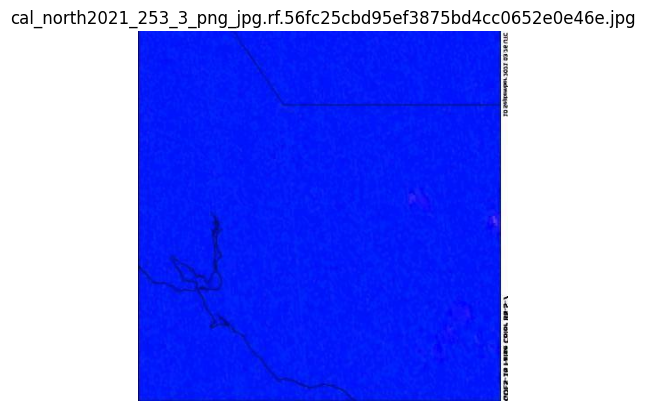

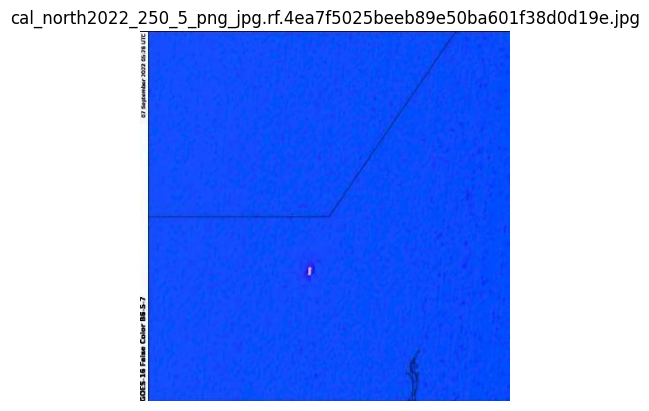

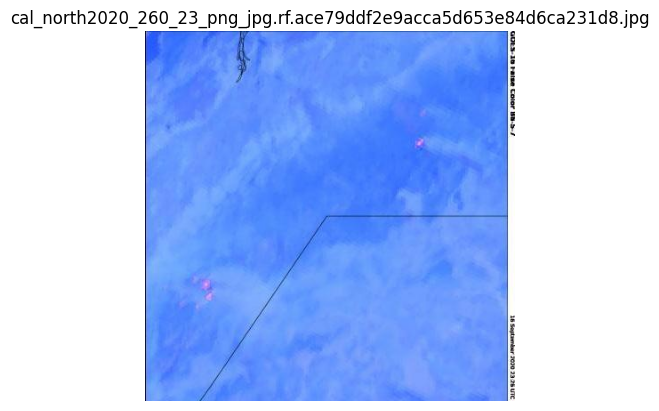

In [ ]:
import random

sample_images = random.sample(list(train_df['filename']), 5)
for img_name in sample_images:
    img = Image.open(os.path.join(x_train_dir, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()

### 6 - Revisar duplicados y validar nombres pareados

In [ ]:
duplicates = train_df['filename'].duplicated().sum()
print(f"Im√°genes duplicadas por nombre: {duplicates}")

# Validar nombres pareados
image_files = sorted([f.split('.')[0] for f in os.listdir(x_train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
label_files = sorted([f.split('.')[0] for f in os.listdir(y_train_dir) if f.endswith('.txt')])

missing_labels = set(image_files) - set(label_files)
missing_images = set(label_files) - set(image_files)

print(f"Im√°genes sin etiqueta: {len(missing_labels)}")
print(f"Etiquetas sin imagen: {len(missing_images)}")

Im√°genes duplicadas por nombre: 0
Im√°genes sin etiqueta: 0
Etiquetas sin imagen: 0


### 7 - Revisar proporciones

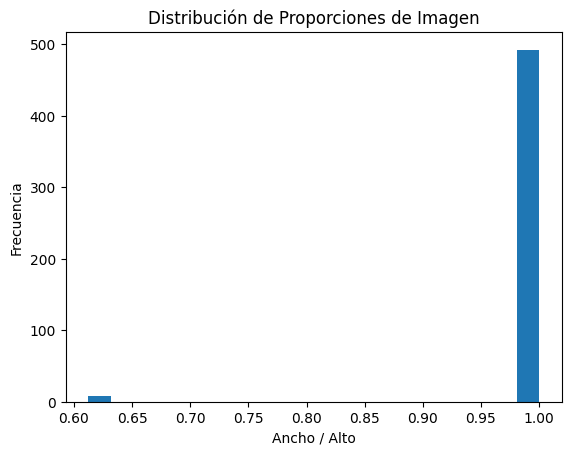

In [ ]:
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
plt.hist(train_df['aspect_ratio'], bins=20)
plt.title("Distribuci√≥n de Proporciones de Imagen")
plt.xlabel("Ancho / Alto")
plt.ylabel("Frecuencia")
plt.show()

**Conclusi√≥nes:**
- Casi todas las im√°genes tienen proporci√≥n ‚âà 1.0 ‚Üí esto indica que son cuadradas.
- Hay un peque√±√≠simo grupo con proporci√≥n ‚âà 0.6, lo cual podr√≠a representar:
  - Algunas im√°genes rectangulares verticales.
  - Las im√°genes quiz√°s sean ruido, mal procesadas o de otra fuente.

### 8 - Visualizaci√≥n de m√∫ltiples im√°genes con sus etiquetas (bounding boxes)

Se genera un mosaico con varias im√°genes del conjunto de entrenamiento.  
Cada imagen se carga junto con su archivo de etiquetas (laberls) en formato YOLO, y se dibujan las bounding boxes correspondientes.

Esto permite inspeccionar visualmente la calidad y consistencia de las anotaciones, as√≠ como observar c√≥mo se representa el humo u otros elementos relevantes en los datos.


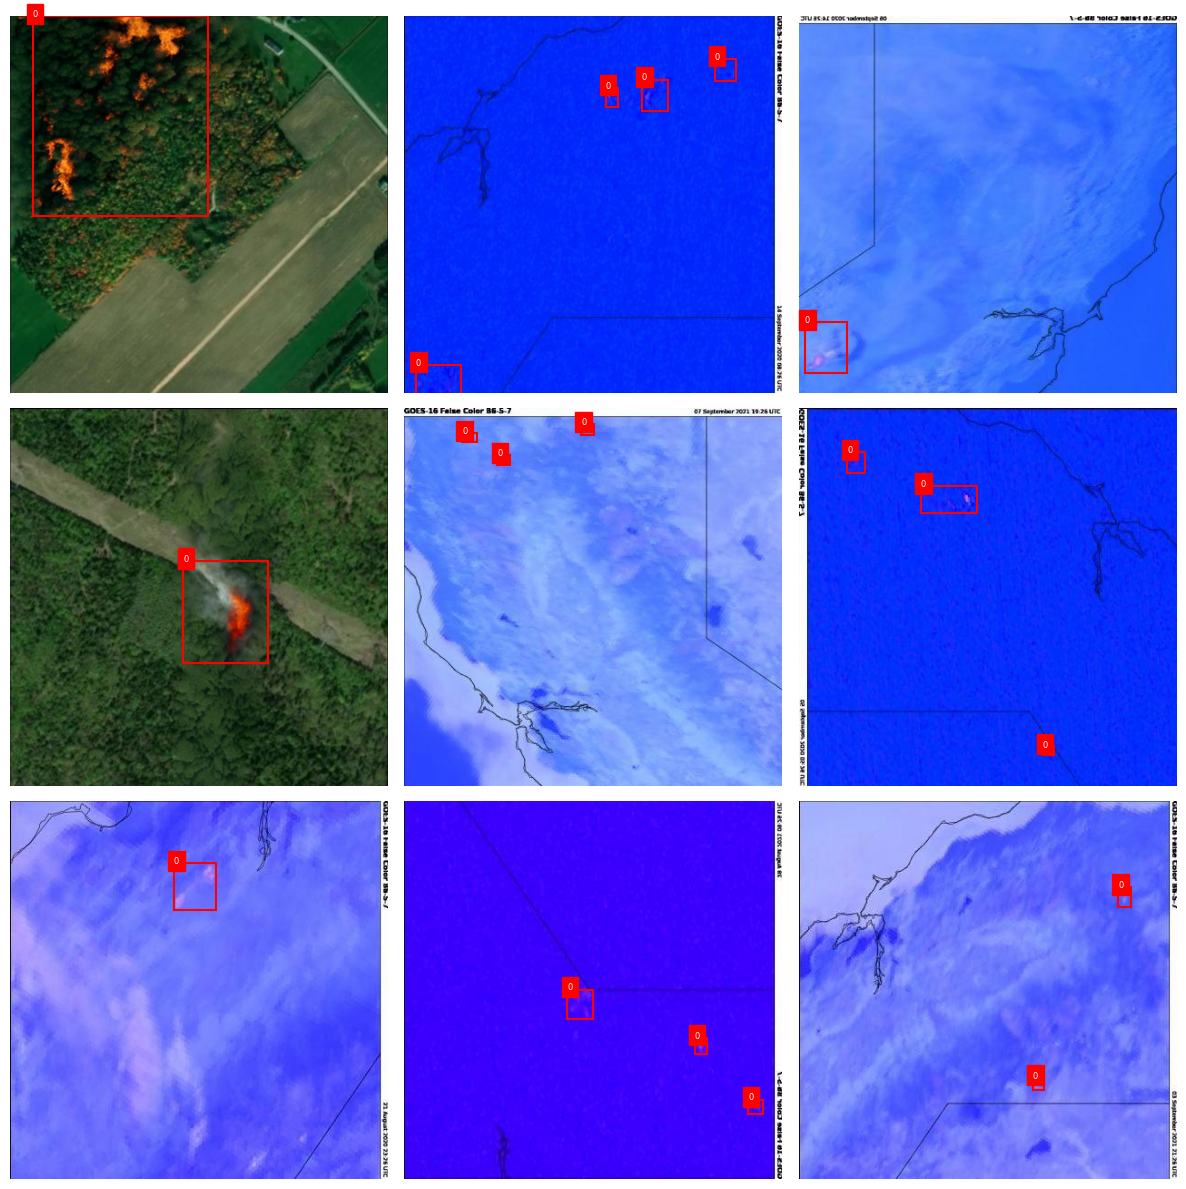

In [ ]:
import matplotlib.patches as patches

def draw_yolo_boxes(image_path, label_path, ax=None):
    with Image.open(image_path) as img:
        if ax is None:
            fig, ax = plt.subplots(1)
        ax.imshow(img)
        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    x = (x_center - bw/2) * w
                    y = (y_center - bh/2) * h
                    width = bw * w
                    height = bh * h
                    rect = patches.Rectangle((x, y), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y, f"{int(cls)}", color='white', fontsize=6, backgroundcolor='red')
        ax.axis('off')

# Mosaico de 9 im√°genes con sus cajas
sample_imgs = random.sample(train_df['filename'].tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for img_name, ax in zip(sample_imgs, axes.flatten()):
    img_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(img_path, label_path, ax=ax)
plt.tight_layout()
plt.show()

### 9 - Distribuci√≥n del √°rea relativa de las bounding boxes

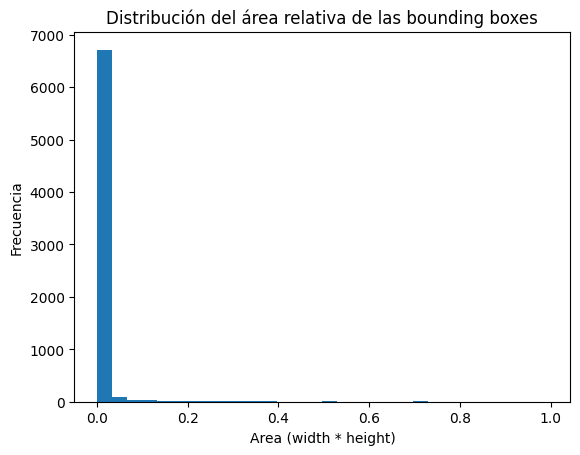

In [ ]:
areas = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h = map(float, parts)
                    areas.append(w * h)

plt.hist(areas, bins=30)
plt.title("Distribuci√≥n del √°rea relativa de las bounding boxes")
plt.xlabel("Area (width * height)")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La gran mayor√≠a de las cajas tienen un √°rea **muy peque√±a** en relaci√≥n con la imagen total.
- Esto indica que el humo detectado suele ocupar zonas localizadas y no extensas.
- Algunas pocas cajas grandes podr√≠an representar incendios m√°s visibles o humo muy denso.

### 10 - Conclusi√≥n del An√°lisis Exploratorio (EDA)

**üîç Conclusiones del EDA:**
- El dataset est√° bien estructurado y dividido en `train`, `val` y `test`.
- Las im√°genes tienen tama√±os y proporciones bastante consistentes (predominan im√°genes cuadradas).
- Las etiquetas est√°n en formato YOLO con bounding boxes, enfocadas en la detecci√≥n de humo.
- La mayor√≠a de las im√°genes tienen entre 1 y 5 objetos etiquetados.
- Las cajas son en su mayor√≠a peque√±as, lo que indica que el modelo deber√° detectar objetos de tama√±o reducido.

---

**üõ† Pr√≥ximos pasos sugeridos:**

1. **Preprocesamiento**:
   - Redimensionar im√°genes a un tama√±o fijo (ej. 640√ó640).
   - Normalizar valores de p√≠xel.
   - Filtrar outliers si se desea (im√°genes muy distintas en tama√±o o proporci√≥n).

2. **Aumento de datos (data augmentation)**:
   - Rotaciones, flips, cambios de brillo o contraste para robustecer el modelo frente a variaciones.

3. **Entrenamiento del modelo**:
   - Usar un modelo de detecci√≥n como YOLOv5/v8 con las anotaciones ya existentes.
   - Monitorear m√©tricas como `mAP`, `recall`, `precision` durante validaci√≥n.

4. **Evaluaci√≥n y mejora**:
   - Ver ejemplos de falsas detecciones.
   - Ajustar umbrales de confianza o refinar etiquetas si es necesario.

---

**üöÄ T√©cnicas avanzadas aplicables (futuras extensiones)**

- **GradCAM**: para visualizar qu√© zonas de la imagen son utilizadas por el modelo para tomar decisiones. √ötil para validar que el modelo realmente detecta humo.
- **Visual Transformers (ViT, DETR)**: alternativas modernas a YOLO, con atenci√≥n global y potencial para mejor rendimiento en detecci√≥n.
- **GANs**: generaci√≥n de im√°genes sint√©ticas de humo para enriquecer el dataset si se requiere mayor variedad visual.
- **Aprendizaje no supervisado**: para explorar agrupamientos naturales de im√°genes o detectar outliers.
- **Segmentaci√≥n sem√°ntica**: si se dispone de m√°scaras detalladas, permite predecir con mayor precisi√≥n la extensi√≥n del humo.